<a href="https://colab.research.google.com/github/whitejetyeh/RBMIsing/blob/master/RBM_Ising_Model(June_19).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction


From the physics point of view, Restrictive Boltzmann Machine (RBM), [Hinton and Salakhutdinov (07)](https://www.cs.toronto.edu/~hinton/science.pdf), extracts features of stochastic distributions in a coarse-graining process based on the concept of renormalization group (RG), see
[Mehta and Schwab (14)](https://arxiv.org/abs/1410.3831). The standard RG procedure aims to extract the (scale-invariant) relevant features of a physical system at large scale by firstly marginalizing out the short distance degrees of freedom and secondly rescaling the system back with lower resolutions. Through iterative coarse-graining (marginalize and rescale), only relevant features are preserved in the renormalized system. Metha and Schwab (14) compared this coarse-graining procedure to how RBM encodes the information passing from the visual layer to the hidden layer in the context of the Ising model.

Even though the exact map between RBM and RG depends on choosing the cost function in RBM concerning the relevant features in RG as criticized in [Lin et al. (17)](https://arxiv.org/abs/1608.08225), [Koch-Janusz and Ringel (18)](https://arxiv.org/abs/1704.06279) demonstrated that RBM is capable of extracting relevant features acquired in a general RG procedure. Here, we explicitly examed the information on visual and hidden layers to show that the hidden layer is not the coarse-grained visual layer as claimed in the exact map. 

The relevant features exist in the coarse-grained system in RG, but RBM keeps the features learned in weight and bias parameters, not the hidden layer.
The proper analogy is to describe the reconstructed visual layer of RBM as the rescaled and coarse-grained system in RG. The hidden layer is merely an intermediate step of RBM with no counterpart in RG.

To demonstrate how RBM works, we trained an RBM to reconstruct spin distributions and another classifier to read the temperature as the work done in [Iso et al. 18](https://arxiv.org/abs/1801.07172).
(Note: the propose of relating the weight parameters to the recognition of the critical point was disproved recently in [Aoki et al. 19](https://arxiv.org/abs/1901.03817).)
The spin distributions in the Ising model are stochastically generated binary values on a finite dimensional grid with periodic boundary conditions.


Ising model exhibits many statistical properties observed similarly in economics, e.g., agents deciding to buy or sell in the stock market
[Sornette & Zhou (05)](https://arxiv.org/abs/cond-mat/0503607),
[Sornette (14)](https://arxiv.org/abs/1404.0243v1), and references therein.
It is interesting to find that the characteristic length in a stochastic distribution can be easily learned by a neural network. 
Along the lines of an RBM reconstructs arbitrary inputs into distributions at the critical temperature, it is possible to construct an unsupervised learning to identify the phase transition of a stochastic distribution without any prior knowledge, where the transition distinguishes the herding phase of strong correlations and the chaotic phase with weak correlations.
The application on Ising economics would be another interesting project in the future.


This project has three parts. The first two parts are in separate colab documents. The first part, [MCMC Ising Model](https://drive.google.com/open?id=1GTzxGebfb-vao0J4q_CzSwC3SPmWakAd), generates spin distributions from the 2D Ising model with Markov Chain Monte Carlo method. The second part, [Temp Classifier](https://drive.google.com/open?id=10qLExy89EIOC-xR3hcRo_ltklT51bdJC), classifies spin distributions into given temperature labels. The third part is this document RBM Ising Model. 

In the following section, we first briefly introduce the restricted Boltzmann machine and then build one with contrastive divergence method in python. We then train our RBM at a fixed cold temperature, where we find, as expected, the RBM reconstructs the given spin distributions after many iterations from learned cold temperature feature. Further, we reproduce the finding in [Iso et al. 18](https://arxiv.org/abs/1801.07172) that the RBM trained with full temperature spectrum learns the scale invariant feature at the critical temperature $T_C$, and the temp classifier specifies the reconstruction from an arbitrary spin distribution at $T_C$ after enough iterations.

In the last section, we demonstrate with a full spectrum RBM, whether the smaller hidden layer encodes the same feature as the input visual layer in larger dimensions. While the feature of the reconstructed visual layer maintains the general  shape as input, it is deformed toward distributions at $T_C$ in agreement with previous findings. However, the overall distributions on the hidden layer are completely deformed, and temp classifier reads different temperatures randomly. 

Surprisingly, even with a far different distribution in the hidden layer, RBM is able to reconstruct the visual layer similar to the input. RBM does not simply encode a low-resolution version of input on the hidden layer. **By storing the characteristic feature of training data in the weight matrix and bias vectors, RBM molds any input with the shape of the training data through the process passing information back and forth between visual and hidden layers until the reconstructed visual state gains the characteristic feature of training data.** Hence, the full spectrum RBM reconstructs any input into the distributions at $T_C$ because the characteristic feature shared with distributions at all temperature appears most frequently at the critical temperature when the distribution is scale-invariant.

# Restricted Boltzmann Machine (RBM)


RBM is an unsupervised machine learning model consisted of binary variables on two layers, a visible layer taking input data and another hidden layer generated from the input with respect to trained parameters of weight $W$ and bias $(b^{v}, b^{h})$.
The model considers a spin distribution of variables $v$ and $h$ on visible and hidden layers respectively. The variable takes binary values 1/0 to indicate spin up/down. Through the Hamiltonian
$$E(v,h)=-b^{(v)}_iv^i-b^{(h)}_jh^j-v^iW_{ij}h^j,$$
a probability to observe a configuration $(v,h)$ is given by the Boltzmann distribution
$$p(v,h)=\frac{e^{-E(v,h)}}{Z},\ \textrm{where } Z=\sum\limits_{v,h}e^{-E(v,h)}.$$
The Hamiltonian is restricted to intra-layer couplings (hence the name Restricted Boltzmann Machine), and the restriction brings the convenience of computing the conditional probability $p(h|v)$, which then generates the spin distribution $h$ on the hidden layer based on the input distribution $v$ via parameters of weight $W$ and bias $(b^{v},b^{h})$.

The process of learning parameters of weight $W$ and bias $(b^{v},b^{h})$ via the method of **contrastive divergence** (CD-k) is as following.


1.   $W$, $b^{v}$, and $b^{h}$ are initialized randomly, and then one generates $h$ from the input $v$ via $p(v|h)$. 
2.   **Gibbs sampling**: denoting $(v,h)$ as $(v^{(0)},h^{(0)})$, one can iteratively reproduce $v^{(k)}$  from $h^{(k-1)}$ with $p(v^{(k)}|h^{(k-1)})$ and $h^{(k)}$ from $v^{(k)}$ with $p(h^{(k)}|v^{(k)})$ by k Gibbs steps.
3. to learn from $N$ samples, weight and biases are updated by adding 
$$\begin{align*}\Delta W_{ij}&=\frac{1}{N}\sum\limits_{a\in \textrm{samples}}v_i^{(0)}h_j^{(0)}-\frac{1}{N}\sum\limits_{a\in \textrm{samples}}v_i^{(k)}h_j^{(k)},\\
\Delta b^{v}_{i}&=\frac{1}{N}\sum\limits_{a\in \textrm{samples}}v_i^{(0)}-\frac{1}{N}\sum\limits_{a\in \textrm{samples}}v_i^{(k)},\\
\Delta b^{h}_{j}&=\frac{1}{N}\sum\limits_{a\in \textrm{samples}}h_j^{(0)}-\frac{1}{N}\sum\limits_{a\in \textrm{samples}}h_j^{(k)}.\end{align*}$$
4. repeat steps 2 and 3 with updated weight and biases.

Until this point, one is ready to implement RBM. Furthermore, to form a **deep belief network**, one can stack many RBMs on top of each other by feeding the next level RBM's visible layer with the hidden layer of a lower level RBM. Following paragraphs are devoted for theoretical details of RBM.
The recommended references of RBMs are [Hinton (10)](https://www.cs.toronto.edu/~hinton/absps/guideTR.pdf) and
[Salakhutdinov et al. (07)](http://www.cs.utoronto.ca/~hinton/absps/netflixICML.pdf).


## Spin distributions on Visible and Hidden layers
To compute spin distributions, we don't directly write out the probability $p(v,h)$ because of the difficulty summing all possible states in the partition function $Z$. However, due to the absence of the intra-layer interactions, it is easy to derive the conditional probabilities of $p(h|v)$ and $p(v|h)$ explicitly.

First, consider the condional probabilities as the products of probability of each spin, $p(h|v)=\prod_i p(h_j=1|v)$ and $p(v|h)=\prod_i p(v_i=1|h)$, and then it's straighforward to eliminate $Z$ in each conditional spin probability as
$$P(h_j=1|v)=\frac{\sum\limits_{\{h|h_j=1\}}p(v,h)}{\sum\limits_{h}p(v,h)}=\mathrm{sigmod}\left(b^{(h)}_j+v^iW_{ij} \right)$$
and
$$P(v_i=1|h)=\frac{\sum\limits_{\{v|v_i=1\}}p(v,h)}{\sum\limits_{v}p(v,h)}=\mathrm{sigmod}\left(b^{(v)}_i+W_{ij} h^j \right),$$
where $\mathrm{sigmod}(x)=\frac{1}{1+exp(-x)}$.

Second, the spin distribution on a layer is decided from the input on another layer by the Monte Carlo method (throwing a dice). For example, with the input $v$ and a dice randomly choosing a value in $[0,1]$, $h_j=1$ if dice$>p(h_j=1|v)$, otherwise $h_j=0$.

### Kullback-Leibler divergence (i.e. cross entropy)
The principle to update parameters is to minimized the Kullback-Leibler divergence, 
$$KL(q||p)=\sum\limits_v q(v) \log\frac{q(v)}{p(v)},$$
which measures the difference between the data probability distribution $p(v)=\sum_h p(v,h)$ and the true probability distribution $q(v)$. With a large but finite number of samplings, $p(v)$ is closed to $q(v)$. Note, $KL(q||p)=-\sum_vq(v)\log p(v)\textrm{(cross entropy)}-\textrm{(system entropy=const.)}$, so minimizing KL divergence is the same as minimizing the cross entropy, which is much frequently used in the data science field.

KL divergence (positive semifefinite) will be smaller by updating parameters with gradient descent, e.g. $W_{ij}=W_{ij}^{0}-\epsilon\frac{\partial KL}{\partial W_{ij}}$, where $\epsilon$ is the learning rate as an extra parameter. Very beutifully, one finds
$$\begin{align*}-\frac{\partial KL}{\partial W_{ij}}&=\left\langle v_i h_j\right\rangle_{\textrm{data}}-\left\langle v_i h_j\right\rangle_{\textrm{model}},\\
-\frac{\partial KL}{\partial b_{i}^{(v)}}&=\left\langle v_i\right\rangle_{\textrm{data}}-\left\langle v_i\right\rangle_{\textrm{model}},\\
-\frac{\partial KL}{\partial b_{j}^{(h)}}&=\left\langle h_j\right\rangle_{\textrm{data}}-\left\langle h_j\right\rangle_{\textrm{model}},\end{align*}$$
where expectations are defined by
$$\begin{align*}\left\langle x(v)\right\rangle_{\textrm{data}}&=\sum\limits_v q(v) x(v),\\
\left\langle y(v,h)\right\rangle_{\textrm{model}}&=\sum\limits_{v,h} p(v,h)y(v,h).\end{align*}$$
### Gibbs sampling
To minimize $KL(q||p)$, one faces the difficulty of computing $p(v,h)$ once again. Similar to the mean field approximation in statistical physics, the contrastive divergence method suggests that Gibbs sampling runs a Markov chain to find the k-steps stochastic reconstruction 
$$v^{(k)}_i \approx p(v^{(k)}_i|h^{(k-1)})\textrm{ and }h^{(k)}_j \approx p(h^{(k)}_j|v^{(k)}),$$
which distributes in the neighborhood of $v^{0}_i$ and $h^{0}_j$ with respect to $p(v,h)$
and therefore $N$ stochastic reconstructions from the dataset helps us to approximate $$\sum\limits_{v,h} p(v,h)y(v,h)\approx \frac{1}{N}\sum\limits_{a \in \textrm{samples}}y(v^{(k)},h^{(k)}).$$

Suprisingly, although $k$ needs to be big enough for the Markov chain to converge, $k=1$ often gives good results, see ref(Bengio & Delalleau, 2007)

According to ref(Hinton 2010-003), it's important to sample binary values on the data-driven hidden layer $h^{(0)}$, i.e. to pick 1 or 0 with probability $p(h_j=1|v)$. The fact that a hidden variable can convey at most one bit creates the information bottleneck, which acts as a strong regularizer. On the other hand, it is better to directly use the real-valued probabilities $p(v^{(l)}_i|h^{(l-1)})$ and $p(h^{(l)}_i|v^{(l)})$ as the stochastic reconstruction $v^{(l)}$ and $h^{(l)}$ for $l\geq 1$ to reduce sampling noise thus allowing faster learning.
Accordingly the code here  applies real-valued probabilities on all layers in Gibbs sampling except two first layers $v^{(0)}$ and $h^{(0)}$, which take a binary value from (1, 0).

## Python code for RBM
RBMcdk is a class defined for restrictive boltzmann machine with CD-k method. 
One builds a model X with V and H variables in visible and hidden layers respectively by 

```
X = RBMcdk(V,H).
```
The input data D with N samples of V-dimensional arrays shall be shaped as a 2D-array of (dim_0=N, dim_1=V).
With CD-k method, one then trains the model X in N epochs with learning rate L by

```
X.contrastive_divergence(D,iterations=N,k=k).
```

After X is trained, Nd samples in a dataset Dd (dim_0=Nd, dim_1=V) can be processed into reconstructed Dd_recon by kd Gibbs steps with X by

```
Dd_recon = gibbs_sampling(Dd, X, k=kd, return_state).
```

For *return_state = V_gibbs, H_gibbs, or H_data*,  *gibbs_sampling* returns the gibbs visual state $v^{(k)}$, the gibbs hidden state $h^{(k)}$, or the data driven hidden state $h^{(0)}$ respectively.

 

In [0]:
import numpy as np
import matplotlib.pyplot as plt
import time
from scipy.special import expit # sigmoid

# Functions useful in RBM
def cond_prob(states, weight, bias):
        # conditional probability
        Nsamples = len(states)
        stacked_bias = np.stack([bias for _ in range(Nsamples)],axis=0)
        return expit(np.matmul(states, weight) + stacked_bias)
    
def MC_selection(probabilities):
        # stochastically sample binary values with given probabilities
        # compare probabilities P with a random tensor T in the same shape; 
        # return 1 for P > T or 0 for P <= T; P must be in [0,1].
        coins = np.random.uniform(0,1,np.shape(probabilities))
        return np.ceil(probabilities-coins)

# Building RBM
class RBMcdk:
    '''Restrctive Boltzmann Machine with CD_k method'''
    def __init__(self, visible_dim, hidden_dim): 
      
        #initialize weight and biases
        np.random.seed(624) # fix the same random initial values
        self.weight = np.random.normal(loc=0,scale=0.1,size=[visible_dim, hidden_dim])
        self.visible_bias = np.random.uniform(low=0,high=1,size=[visible_dim])
        self.hidden_bias = np.random.uniform(low=0,high=1,size=[hidden_dim])
        
    
    def contrastive_divergence(self, data, iterations, k=1, learning_rate=0.1, text_out=False):
        # data input = [v1,v2,...,vN] for N samples, v_dim = [visible_dim]
        start = time.time() # timing training process
        
        Nsamples = len(data)
        print("Number of samples = ",Nsamples," with data dimension = ",len(data[0]))        
        
        for i in range(iterations):
                
            # initialize data-driven hidden layer
            # state dimensions = (Nsamples, layer dim)
            self.hidden_state = MC_selection(cond_prob(data, 
                                                       self.weight, 
                                                       self.hidden_bias)) 
            
            #Gibbs sampling iteration
            #CD1
            self.visible_gibbstate = cond_prob(self.hidden_state, 
                                               np.transpose(self.weight), 
                                               self.visible_bias)
            self.hidden_gibbstate = cond_prob(self.visible_gibbstate, 
                                              self.weight, 
                                              self.hidden_bias)
            #CDK>1
            for j in range(k-1):
                self.visible_gibbstate = cond_prob(self.hidden_gibbstate, 
                                                   np.transpose(self.weight), 
                                                   self.visible_bias)
                self.hidden_gibbstate = cond_prob(self.visible_gibbstate, 
                                                  self.weight, 
                                                  self.hidden_bias)
            
            # update weight and biases Contrastive Divergence
            
            # <vh>_data
            vh_data = np.matmul(np.transpose(data),self.hidden_state)/Nsamples
            # <vh>_model
            vh_model = np.matmul(np.transpose(self.visible_gibbstate),
                                 self.hidden_gibbstate)/Nsamples
            self.weight += learning_rate*(vh_data-vh_model) # weight update
            
            v_data = np.mean(data,axis=0) # <v>_data
            v_model = np.mean(self.visible_gibbstate,axis=0) # <v>_model
            self.visible_bias += learning_rate*(v_data-v_model) # v_bias update
            
            h_data = np.mean(self.hidden_state,axis=0) # <h>_data
            h_model = np.mean(self.hidden_gibbstate,axis=0) # <h>_model        
            self.hidden_bias += learning_rate*(h_data-h_model) # h_bias update
          
        end = time.time() # timing training process
        print('training completed within ',end-start)
        
        # save trained weight and biases for big data
        if text_out:
            file_name = time.localtime(time.time()) # use mins+secs as the name
            file_name = str(file_name.tm_min)+str(file_name.tm_sec)
            path = '/content/gdrive/My Drive/IsingModel/'
                        
            file_path = path+file_name+'_weight.csv'
            with open(file_path,'wb+') as f:
                np.savetxt(f,self.weight,fmt='%g',delimiter=',')
                
            file_path = path+file_name+'_vbias.csv'
            with open(file_path,'wb+') as f:
                np.savetxt(f,self.visible_bias,fmt='%g',delimiter=',')
                
            file_path = path+file_name+'_hbias.csv'
            with open(file_path,'wb+') as f:
                np.savetxt(f,self.hidden_bias,fmt='%g',delimiter=',')
            print('Print model to %s_weight/bias.csv for big data' % (file_name,))
      
            

In [0]:
def gibbs_sampling(data, trained_rbm, k=1, return_state='V_gibbs'):    
    
    # data driven hidden layer
    hidden_state = MC_selection(cond_prob(data, 
                                          trained_rbm.weight, 
                                          trained_rbm.hidden_bias)) 
            
    #Gibbs sampling iteration for data reconstruction
    #CD1
    visible_gibbstate = cond_prob(hidden_state, 
                                  np.transpose(trained_rbm.weight), 
                                  trained_rbm.visible_bias)
    hidden_gibbstate = cond_prob(visible_gibbstate, 
                                 trained_rbm.weight, 
                                 trained_rbm.hidden_bias)
    #CDK>1
    for j in range(k-1):        
        visible_gibbstate = cond_prob(hidden_gibbstate, 
                                      np.transpose(trained_rbm.weight), 
                                      trained_rbm.visible_bias)
        hidden_gibbstate = cond_prob(visible_gibbstate, 
                                     trained_rbm.weight, 
                                     trained_rbm.hidden_bias)
    # reconstructed layers
    visible_gibbstate = MC_selection(visible_gibbstate)
    hidden_gibbstate = MC_selection(hidden_gibbstate)
    
    if return_state == 'V_gibbs':
        return visible_gibbstate
    elif return_state == 'H_gibbs':
        return hidden_gibbstate
    elif return_state == 'H_data':
        return hidden_state
    else:
        print('calling invalid return_state')
        return visible_gibbstate

The following code demonstrates how to run RBMcdk with a short piece of code. When test data is a stack of the same vector, RBMcdk easily captures the repeated feature with few iterations, and the reconstruction replicates the input test data. Furthermore, given another different vector, its reconstruction after few Gibbs steps also replicate the original test data. **This indicates a strong feature learned in RBM will merge in any data after enough Gibbs steps**. 

In [0]:
'''This part is a small test for repeated data. 
   Expect to find the same visible_gibbstate as testdata 
   because rbm shall find clear feature in repeated data.'''

testdata = np.array([[0,1,1,0,1], [0,1,1,0,1], [0,1,1,0,1], [0,1,1,0,1]]) # repeat the same data
#testdata = np.array([[0,1,1,0,1], [0,1,0,0,1], [0,0,1,0,1], [0,0,1,0,1]]) # less similar data

# set RBM by entering dimensions of visible, hidder layers
testrbm = RBMcdk(5,5)

# put data in RBM with CDk method
testrbm.contrastive_divergence(testdata,iterations=50,k=2)

print('\n trained reconstructed visible states = \n',testrbm.visible_gibbstate)
stacked_data = np.stack(testdata,axis=0)
reconstruction_error = np.sum((testrbm.visible_gibbstate-stacked_data)**2)
print('\n reconstruction error = ',reconstruction_error)

# process validation data with trained RBM
# the validation data flows into the training data because of the repeated feature
validation_data = np.array([[1,1,0,1,1]])
reconstruction_data = gibbs_sampling(validation_data, testrbm, k=5)
print('\n %s is reconstructed to %s' % (str(validation_data), 
                                        str(reconstruction_data)))

Number of samples =  4  with data dimension =  5
training completed within  0.010631799697875977

 trained reconstructed visible states = 
 [[0.03986688 0.96451554 0.96617885 0.04179925 0.9677512 ]
 [0.03986688 0.96451554 0.96617885 0.04179925 0.9677512 ]
 [0.04114863 0.96335767 0.96523498 0.04332622 0.96670981]
 [0.03986688 0.96451554 0.96617885 0.04179925 0.9677512 ]]

 reconstruction error =  0.02756851475775112

 [[1 1 0 1 1]] is reconstructed to [[-0.  1.  1. -0.  1.]]


## RBM learning a cold Ising Model

In this subsection, we train an RBM, *Cold_IsingRBM*, to learn the general features of spin distributions at a fixed temperature $T=0.27$, which is lower than the critical temperature $T_C=2.27$ on the 2D grid. At a cold temperature, spins tend to flip together and form big chunk of areas with the same direction. 

Here, we mount a google drive with datasets of spin distributions in the Ising model.

In [0]:
# mount google drive
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


Load spin data at $T=0.27$ and shuffle them for training as the following


In [0]:
'''
Read Ising Model spin distributions at given temperatures to train RBM
'''
# given temperature labels from data set
temperatures=[0.27]

# Load spin data from CSV file
def acquire_spin_data(file, dataset):    
    raw_data = np.loadtxt(file,delimiter=",")
    raw_data = (raw_data+1)/2 # scale data from spin=(1,-1) to (1,0)
    #raw_data=raw_data.reshape((2000,400)) # reshape to 2k data of 20^2 flatten grid
    raw_data=raw_data.reshape((2000,100)) # reshape to 2k data of 10^2 flatten grid
    # tensor_util.py in tf takes only plain python lists or tuples but not numpy arrays
    raw_data=raw_data.astype(np.float32).tolist() 
    dataset.extend(raw_data)

train_data, test_data = [], []
train_labels, test_labels = [], []
ind = 0 # counter for the labels
for temp in temperatures:
    train_file = '/content/gdrive/My Drive/IsingModel/training2k/t='+str(temp)+'.csv'
    test_file = '/content/gdrive/My Drive/IsingModel/validation2k/t='+str(temp)+'.csv'
    acquire_spin_data(train_file, train_data)
    acquire_spin_data(test_file, test_data)
    train_labels += [ind]*2000
    test_labels += [ind]*2000
    ind += 1

# shuffle dataset and labels simutaneously
# array indexing
def unity_shuffled_copies(a, b):
    assert len(a) == len(b)
    p = np.random.permutation(len(a))
    return a[p], b[p]

train_data,train_labels=unity_shuffled_copies(np.array(train_data),np.array(train_labels))


Load the [temperature classifier](https://drive.google.com/open?id=10qLExy89EIOC-xR3hcRo_ltklT51bdJC), which is a trained neural network classifing spin distributions into different temperature labels. The classifier loaded here specifies the temperatures from three groups of spin distributions at $T=\{0.27,2.27,4.27\}$ with accuracy 99%.

In [0]:
'''
Load temperature classifier, which is a pretrained neural network
'''
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

classified_temp=[0.27, 2.27, 4.27]
#classified_temp=[0.27, 1.27, 2.27, 3.27, 4.27]

# load model and architecture from a single file
save_path = '/content/gdrive/My Drive/IsingModel/'
model_name = 'temp_classifier_100_256_512_3.h5'
model = keras.models.load_model((save_path+model_name))

model.summary() # print the architecture of the model

# evaluate accuracy
test_loss, test_acc = model.evaluate(np.array(test_data).reshape((2000,10,10)),[0]*2000)
# needs to set up labels manually for different temperature input
# 3 labels: [0] for 0.27, [1] for 2.27, [2] for 4.27
# 5 labels: [0] for 0.27, [1] for 1.27, [2] for 2.27, [3] for 3,27, [4] for 4.27
print('Test accuracy:', test_acc)


W0616 20:20:27.622460 139943656740736 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/init_ops.py:97: calling GlorotUniform.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W0616 20:20:27.623988 139943656740736 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W0616 20:20:27.627388 139943656740736 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/init_ops.py:97: calling Zeros.__init__ (from tensorflow.python.ops.init_ops) with dtyp

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 100)               0         
_________________________________________________________________
dense (Dense)                (None, 256)               25856     
_________________________________________________________________
dense_1 (Dense)              (None, 512)               131584    
_________________________________________________________________
dense_2 (Dense)              (None, 3)                 1539      
Total params: 158,979
Trainable params: 158,979
Non-trainable params: 0
_________________________________________________________________
2000/2000 [==============================] - 1s 422us/sample - loss: 0.0173 - acc: 0.9955
Test accuracy: 0.9955


Cold_IsingRBM has 100 visual variables taking spin distributions on a 10 by 10 grid and 64 hidden variables.
Trained weight and biases will be saved in csv files if *text_out=True*.
It takes about 2 minutes to compute 2,000 epochs with 2000 samples on a $10^2$ grid. With GPU acceleration, the time is shorten to 1.5 minutes (1.3 times faster).

In [0]:
'''
train RBMcdk with Ising Model
'''

# set RBM by entering dimensions of visible, hidder layers
Cold_IsingRBM = RBMcdk(100,64)

# put data in RBM with CDk method
Cold_IsingRBM.contrastive_divergence(train_data,
                                     iterations=2000,
                                     k=2,
                                     text_out=0)


Number of samples =  2000  with data dimension =  100
training completed within  92.69297671318054
Print model to 4516_weight/bias.csv for big data


Load trained model as *loaded_RBM*

In [0]:
'''Load Trained Model from csv files'''
loaded_RBM = RBMcdk(100,64) # need to know the dimensions of the loaded model

file_name = str(2538) #saved model's time stamp, found in message above
path = '/content/gdrive/My Drive/IsingModel/'
                       
file_path = path+file_name+'_weight.csv'    
loaded_RBM.weight = np.loadtxt(file_path,delimiter=",")

file_path = path+file_name+'_vbias.csv'    
loaded_RBM.visual_bias = np.loadtxt(file_path,delimiter=",")                       

file_path = path+file_name+'_hbias.csv'    
loaded_RBM.hidden_bias = np.loadtxt(file_path,delimiter=",")


Plot reconstructed visual states after 2000 epochs and compare with the input, which is independent from the training_data, at the same temperature. 


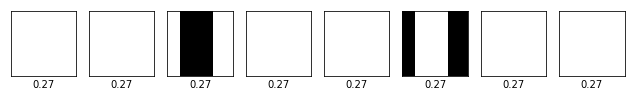

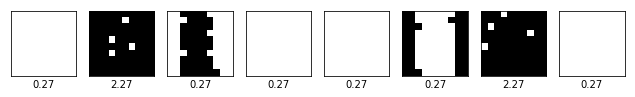

In [0]:
#import matplotlib.pyplot as plt

# plot 8 spin distributions from the validation dataset
np.random.seed(1)
validation_data = [0]*8
ind=np.random.randint(0,1999)
plt.figure(figsize=(11,11))
for i in range(8):
    validation_data[i] = test_data[ind+i] #pick random 8 data
    plt.subplot(1,8,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(np.reshape(validation_data[i],(10,10)), cmap=plt.cm.binary)
    plt.xlabel(temperatures[test_labels[ind+i]])
plt.show()

# RECONSTRUCTION of validation test with trained RBM
# plot 8 spin distributions from the reconstructed validation dataset

# process validation data with trained RBM
reconstructed_data = gibbs_sampling(validation_data, loaded_RBM, k=2000)
#reconstructed_data = gibbs_sampling(validation_data, Cold_IsingRBM, k=2000)
reconstructed_label = [0]*8
plt.figure(figsize=(11,11))
for i in range(8):
    
    # identify temperature with Temp Classifier
    img = np.reshape(np.array(reconstructed_data[i]),(10,10))
    img = (np.expand_dims(img,0)) # Add the image to a batch where it's the only member.
    predictions = model.predict(img)
    reconstructed_label[i] = np.argmax(predictions)
    
    plt.subplot(1,8,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(np.reshape(reconstructed_data[i],(10,10)), cmap=plt.cm.binary)
    plt.xlabel(classified_temp[reconstructed_label[i]])
plt.show()

The similar input and reconstructed data indicate the Cold_IsingRBM can maintain the feature learned at a fixed temperature as expected. The reconstruction differs with few pixels due to the stochastic process. Notice that the system does not distinguish the all spin up distribution from the all spin down one, so all white plot is considered the same as all black plot. With few pixels flipped, temp classifier reads higher temperatures from the almost all white/black plot especially due to the very short characteristic length from few pixels. This problem can be solved with higher resolutions or simply by discarding all white/black data at low temperature. 

## RBM learning Ising Model from cold to hot

With data from the full spectrum, we train the RBM to find how the general feature shared from low to high temperature adopts arbitrary input into the distributions at the critical temperature. 

We demonstrate the training with the data on a 10 by 10 grid with three temperature labels $\{0.27,2.27,4.27\}$. Waiting for the longer computation time, one can change to the data on a 20 by 20 grid for a higher resolution. However, due to the stochastic nature on the finite dimensional grid, the accuracy of temp classifier is significantly lower with five or more temperature labels.


In [0]:
'''
Read Ising Model spin distributions at given temperatures to train RBM
'''
# given temperature labels from data set
#temperatures=[0.27, 1.27, 2.27, 3.27, 4.27]
temperatures=[0.27, 2.27, 4.27]

# Load spin data from CSV file
def acquire_spin_data(file, dataset):    
    raw_data = np.loadtxt(file,delimiter=",")
    raw_data = (raw_data+1)/2 # scale data from spin=(1,-1) to (1,0)
    #raw_data=raw_data.reshape((2000,400)) # reshape to 2k data of 20^2 flatten grid
    raw_data=raw_data.reshape((2000,100)) # reshape to 2k data of 10^2 flatten grid
    # tensor_util.py in tf takes only plain python lists or tuples but not numpy arrays
    raw_data=raw_data.astype(np.float32).tolist() 
    dataset.extend(raw_data)

train_data, test_data = [], []
train_labels, test_labels = [], []
ind = 0 # counter for the labels
for temp in temperatures:
    train_file = '/content/gdrive/My Drive/IsingModel/training2k/t='+str(temp)+'.csv'
    test_file = '/content/gdrive/My Drive/IsingModel/validation2k/t='+str(temp)+'.csv'
    acquire_spin_data(train_file, train_data)
    acquire_spin_data(test_file, test_data)
    train_labels += [ind]*2000
    test_labels += [ind]*2000
    ind += 1

# shuffle dataset and labels simutaneously
# array indexing
def unity_shuffled_copies(a, b):
    assert len(a) == len(b)
    p = np.random.permutation(len(a))
    return a[p], b[p]

train_data,train_labels=unity_shuffled_copies(np.array(train_data),np.array(train_labels))

'''
Load temperature classifier, which is a pretrained neural network
'''
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

classified_temp=[0.27, 2.27, 4.27]
#classified_temp=[0.27, 1.27, 2.27, 3.27, 4.27]

# load model and architecture from a single file
save_path = '/content/gdrive/My Drive/IsingModel/'
model_name = 'temp_classifier_100_256_512_3.h5'
model = keras.models.load_model((save_path+model_name))

model.summary() # print the architecture of the model

# evaluate accuracy
test_loss, test_acc = model.evaluate(np.array(test_data).reshape((2000*3,10,10)),
                                     [0]*2000+[1]*2000+[2]*2000)
# needs to set up labels manually for different temperature input
# 3 labels: [0] for 0.27, [1] for 2.27, [2] for 4.27
# 5 labels: [0] for 0.27, [1] for 1.27, [2] for 2.27, [3] for 3,27, [4] for 4.27
print('Test accuracy:', test_acc)



Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 100)               0         
_________________________________________________________________
dense (Dense)                (None, 256)               25856     
_________________________________________________________________
dense_1 (Dense)              (None, 512)               131584    
_________________________________________________________________
dense_2 (Dense)              (None, 3)                 1539      
Total params: 158,979
Trainable params: 158,979
Non-trainable params: 0
_________________________________________________________________
6000/6000 [==============================] - 0s 44us/sample - loss: 0.1006 - acc: 0.9657
Test accuracy: 0.96566665


Full_IsingRBM takes about 6 minutes to compute 2,000 epochs with 6,000 samples on a 10^2 grid. With GPU acceleration, the time is shorten to 5 minutes (1.2 times faster).

In [0]:
'''
train RBMcdk with Ising Model
'''

# set RBM by entering dimensions of visible, hidder layers
Full_IsingRBM = RBMcdk(100,64) # full spectrum

# put data in RBM with CDk method
Full_IsingRBM.contrastive_divergence(train_data,
                                     iterations=2000,
                                     k=2,
                                     text_out=0)

Number of samples =  6000  with data dimension =  100
training completed within  295.2187592983246


The following code uses the Full_IsingRBM trained with 10,000 epochs to reconstruct input with 2,000 iterations. The input includes random 8 spin distributions at $T_H=4.27$ and $T_L=0.27$.

Graphs below show sample distributions at T_H = 4.27.


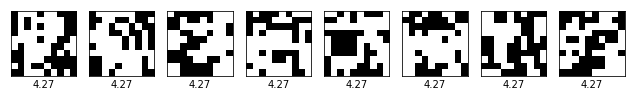

Graphs below show reconstructed distributions.


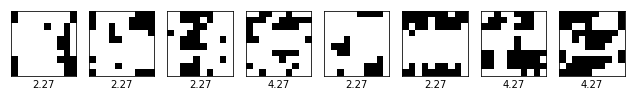

Graphs below show sample distributions at T_L = 0.27.


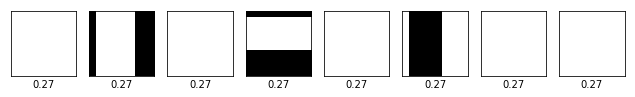

Graphs below show reconstructed distributions.


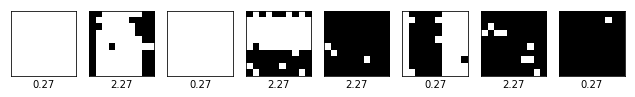

In [0]:
'''Load Trained Model from csv files'''
loaded_RBM = RBMcdk(100,64) # need to know the dimensions of the loaded model

# saved model's time stamp, found in message above
#file_name = str(4546) # 4546 computes 10^2 grid for 2000 epochs.
file_name = str(5118) # 5118 computes 10^2 grid for 10000 epochs.
path = '/content/gdrive/My Drive/IsingModel/'
                       
file_path = path+file_name+'_weight.csv'    
loaded_RBM.weight = np.loadtxt(file_path,delimiter=",")

file_path = path+file_name+'_vbias.csv'    
loaded_RBM.visual_bias = np.loadtxt(file_path,delimiter=",")                       

file_path = path+file_name+'_hbias.csv'    
loaded_RBM.hidden_bias = np.loadtxt(file_path,delimiter=",")

# plot 8 spin distributions from the validation dataset
'''
Full_IsingRBM transforms High T distributions to Critical Tc distribution.
'''
tempind = 2  # pick a temp catagory, (0,1,2) = (T_L,T_C,T_H)
validation_data = [0]*8
np.random.seed(123)

ind = 2000*tempind+np.random.randint(0,1999)
print('Graphs below show %s distributions at %s%g.' % ('sample','T_H = ',temperatures[tempind]))
plt.figure(figsize=(11,11))
for i in range(8):
    validation_data[i] = test_data[ind+i] #pick random 8 data
    plt.subplot(1,8,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(np.reshape(validation_data[i],(10,10)), cmap=plt.cm.binary)
    plt.xlabel(temperatures[test_labels[ind+i]])
plt.show()

# RECONSTRUCTION of validation test with trained RBM
# plot 8 spin distributions from the reconstructed validation dataset

# process validation data with trained RBM
reconstructed_data = gibbs_sampling(validation_data, loaded_RBM, k=2000)
#reconstructed_data = gibbs_sampling(validation_data, Full_IsingRBM, k=2000)
reconstructed_label = [0]*8
print('Graphs below show %s distributions.' % ('reconstructed',))
plt.figure(figsize=(11,11))
for i in range(8):
    
    # identify temperature with Temp Classifier
    img = np.reshape(np.array(reconstructed_data[i]),(10,10))
    img = (np.expand_dims(img,0)) # Add the image to a batch where it's the only member.
    predictions = model.predict(img)
    reconstructed_label[i] = np.argmax(predictions)
    
    plt.subplot(1,8,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(np.reshape(reconstructed_data[i],(10,10)), cmap=plt.cm.binary)
    plt.xlabel(classified_temp[reconstructed_label[i]])
plt.show()

'''
Full_IsingRBM transforms Low T distributions to Critical Tc distribution.
'''
tempind = 0  # pick a temp catagory, (0,1,2) = (T_L,T_C,T_H)
validation_data = [0]*8
np.random.seed(12)

ind = 2000*tempind+np.random.randint(0,1999)
print('Graphs below show %s distributions at %s%g.' % ('sample','T_L = ',temperatures[tempind]))
plt.figure(figsize=(11,11))
for i in range(8):
    validation_data[i] = test_data[ind+i] #pick random 8 data
    plt.subplot(1,8,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(np.reshape(validation_data[i],(10,10)), cmap=plt.cm.binary)
    plt.xlabel(temperatures[test_labels[ind+i]])
plt.show()

# RECONSTRUCTION of validation test with trained RBM
# plot 8 spin distributions from the reconstructed validation dataset

# process validation data with trained RBM
reconstructed_data = gibbs_sampling(validation_data, loaded_RBM, k=2000)
#reconstructed_data = gibbs_sampling(validation_data, Full_IsingRBM, k=2000)
reconstructed_label = [0]*8
print('Graphs below show %s distributions.' % ('reconstructed',))
plt.figure(figsize=(11,11))
for i in range(8):
    
    # identify temperature with Temp Classifier
    img = np.reshape(np.array(reconstructed_data[i]),(10,10))
    img = (np.expand_dims(img,0)) # Add the image to a batch where it's the only member.
    predictions = model.predict(img)
    reconstructed_label[i] = np.argmax(predictions)
    
    plt.subplot(1,8,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(np.reshape(reconstructed_data[i],(10,10)), cmap=plt.cm.binary)
    plt.xlabel(classified_temp[reconstructed_label[i]])
plt.show()

In the graphs above, the first two rows and the last two rows compare the input and corresponding reconstructions after 2,000 iterations of eight distributions at $T_H=4.27$ and $T_L=0.27$. 
Playing with iterations k, (the number of Gibbs steps), one can see how distributions are gradually deformed into the ones at $T_C$. For distributions at $T_H$, the larger chunk of the white/black areas grow even bigger and reflect the shrinking characteristic length toward lower temperature, and distributions at $T_L$ undergo the opposite deformation toward higher temperature.
One can easily compute many Gibbs steps over $k=10,000$ with *gibbs_sampling*. Once the temperature reading turns $T=T_C$, it stays the same while the distribution fluctuates with more Gibbs steps. 

# Information encoded on the hidden layer
With the RBM learned critical features of spin distributions at $T_C$, we exam the information encoded on the hidden layer to find if the hidden state appears as the coarse-grained visual state as claimed in the exact map, [Mehta and Schwab (14)](https://arxiv.org/abs/1410.3831). 
The RBM used here has 144 visual dimensions for spins on a 14 by 14 grid and 100 hidden dimensions for spins on a 10 by 10 grid, and it is trained with full spectrum data to learn the distributions at $T_C$. We then reconstruct several spin distributions at $T_C$ and compare the reconstructed visual and hidden states with the input. While the reconstructed visual states preserve most significant chunks of areas, the data-driven and reconstructed hidden layers do not assemble the input, and the corresponding temperature readings vary randomly. Therefore, we do not view the hidden states as the coarse-grained visual states.





## 1. Load datasets and classifiers

Prepare **train_data** and **test_data** from spin distributions on a 12^2 grid. There are three temperature labels, T_H=4.27, T_C=2.27, T_D=0.27.
Two temp classifiers with 97+% accuracy are loaded. temp_classifier_144_256_512_3 and temp_classifier_100_256_512_3 specify temperature labels from 12^2 and 10^2 grids respectively, and they both have two hidden layers of 256 and 512 neurons.

In [0]:
'''
Read Ising Model spin distributions at given temperatures to train RBM
'''
# given temperature labels from data set
#temperatures=[0.27, 1.27, 2.27, 3.27, 4.27]
temperatures=[0.27, 2.27, 4.27]

# Load spin data from CSV file
def acquire_spin_data(file, dataset):    
    raw_data = np.loadtxt(file,delimiter=",")
    raw_data = (raw_data+1)/2 # scale data from spin=(1,-1) to (1,0)
    raw_data=raw_data.reshape((2000,144)) # reshape to 2k data of 12^2 flatten grid    
    # tensor_util.py in tf takes only plain python lists or tuples but not numpy arrays
    raw_data=raw_data.astype(np.float32).tolist() 
    dataset.extend(raw_data)

train_data, test_data = [], []
train_labels, test_labels = [], []
ind = 0 # counter for the labels
for temp in temperatures:
    train_file = '/content/gdrive/My Drive/IsingModel/training2kd12/t='+str(temp)+'.csv'
    test_file = '/content/gdrive/My Drive/IsingModel/validation2kd12/t='+str(temp)+'.csv'
    acquire_spin_data(train_file, train_data)
    acquire_spin_data(test_file, test_data)
    train_labels += [ind]*2000
    test_labels += [ind]*2000
    ind += 1

# shuffle dataset and labels simutaneously
# array indexing
def unity_shuffled_copies(a, b):
    assert len(a) == len(b)
    p = np.random.permutation(len(a))
    return a[p], b[p]

train_data,train_labels=unity_shuffled_copies(np.array(train_data),np.array(train_labels))

'''
Load temperature classifier, which is a pretrained neural network
'''
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

classified_temp=[0.27, 2.27, 4.27]
#classified_temp=[0.27, 1.27, 2.27, 3.27, 4.27]

# load model and architecture from a single file
save_path = '/content/gdrive/My Drive/IsingModel/'
modeld12_name = 'temp_classifier_144_256_512_3.h5'
modeld12 = keras.models.load_model((save_path+modeld12_name))

modeld12.summary() # print the architecture of the model

# evaluate accuracy
test_loss, test_acc = modeld12.evaluate(np.array(test_data).reshape((2000*3,12,12)),
                                     [0]*2000+[1]*2000+[2]*2000)
# needs to set up labels manually for different temperature input
print('Test accuracy:', test_acc)

modeld10_name = 'temp_classifier_100_256_512_3.h5'
modeld10 = keras.models.load_model((save_path+modeld10_name))

modeld10.summary() # print the architecture of the model

'''
#modeld10 has accuracy~0.97, checked above.
#accuracy is not evaluated again because test_data is on 12^2 grid instead of 10^2 grid.
'''



Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 144)               0         
_________________________________________________________________
dense (Dense)                (None, 256)               37120     
_________________________________________________________________
dense_1 (Dense)              (None, 512)               131584    
_________________________________________________________________
dense_2 (Dense)              (None, 3)                 1539      
Total params: 170,243
Trainable params: 170,243
Non-trainable params: 0
_________________________________________________________________
6000/6000 [==============================] - 0s 47us/sample - loss: 0.0617 - acc: 0.9802
Test accuracy: 0.9801667
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape       

'\n#modeld10 has accuracy~0.97, checked above.\n#accuracy is not evaluated again because test_data is on 12^2 grid instead of 10^2 grid.\n'

## 2. Train the model
Train an RBM (CD-k=2) called Full_encoder, which has a 12^2 dimensional visual layer and a 10^2 dimensional hidden layer. With data from the full temperature spectrum, Full_encoder encodes  spin distributions on a 12^2 grid to spin distributions on a 10^2 grid after 10,000 epochs. 
It takes about 70 minutes to train Full_encoder in 10,000 epochs with 6000 samples on a 20^2 grid (with GPU acceleration).

In [0]:
'''
Full_encoder is an RBM trained to explore how much features are preserved 
after Gibbs sampling. Train_data include T_L=0.27, T_C=2.27, T_H=4.27.
'''

# set RBM by entering dimensions of visible, hidder layers
Full_encoder = RBMcdk(144,100) # full spectrum

# put data in RBM with CDk method
Full_encoder.contrastive_divergence(train_data,
                                    iterations=10000,
                                    k=2,
                                    text_out=True)

Number of samples =  6000  with data dimension =  144
training completed within  2353.962066888809
Print model to 4535_weight/bias.csv for big data


## 3. Graph reconstructions
The following code loads a pre-trained Full_encoder as loaded_RBM and plots four rows of eight graphs. The first row presents 8 samples from test_data. The second row presents the corresponding 8 reconstructed samples on the data-driven hidden layer ($h^{(0)}$). The third and fourth row present the corresponding 8 samples reconstructed after k=2000 Gibbs steps on the visible layer $v^{(k)}$ and the hidden layer $h^{(k)}$.
By choosing the parameter *tempind*=(0,1,2) for $T=(T_L,T_C,T_H)$, the code plots data from every temp label.

Graphs below show sample distributions at T_L = 2.27.


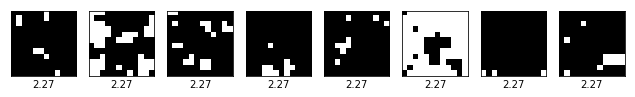

Graphs below show data-driven hidden distributions.


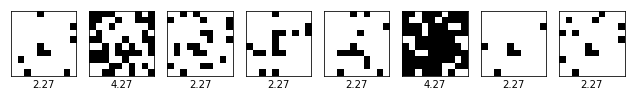

Graphs below show reconstructed visual distributions.


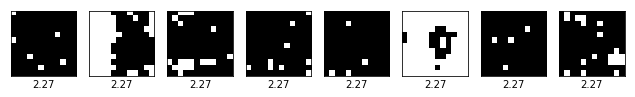

Graphs below show reconstructed hidden distributions.


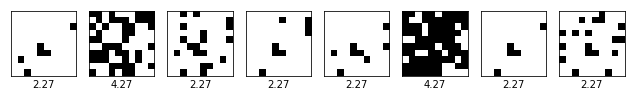

In [0]:
'''Load Trained Model from csv files'''
loaded_RBM = RBMcdk(144,100) # need to know the dimensions of the loaded model

# saved model's time stamp, found in message above
#file_name = str(3223) # 3223 computes 20^2 grid for 2000 epochs. 
#file_name = str(1017) # 1017 computes 20^2 grid for 10000 epochs. 
file_name = str(4535) # 4535 computes 12^2 grid for 10000 epochs. 
path = '/content/gdrive/My Drive/IsingModel/'
                       
file_path = path+file_name+'_weight.csv'    
loaded_RBM.weight = np.loadtxt(file_path,delimiter=",")

file_path = path+file_name+'_vbias.csv'    
loaded_RBM.visual_bias = np.loadtxt(file_path,delimiter=",")                       

file_path = path+file_name+'_hbias.csv'    
loaded_RBM.hidden_bias = np.loadtxt(file_path,delimiter=",")

# plot 8 spin distributions from the validation dataset
'''
Full_encoder reserves visible features in hidden layer at Low T/ High T.
'''
tempind = 1  # pick a temp catagory, (0,1,2) = (T_L,T_C,T_H)
validation_data = [0]*8
np.random.seed(321)

ind = 2000*tempind+np.random.randint(0,1999)
print('Graphs below show %s distributions at %s%g.' % ('sample','T_L = ',temperatures[tempind]))
plt.figure(figsize=(11,11))
for i in range(8):
    validation_data[i] = test_data[ind+i] #pick random 8 data
    plt.subplot(1,8,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(np.reshape(validation_data[i],(12,12)), cmap=plt.cm.binary)
    plt.xlabel(temperatures[test_labels[ind+i]])
plt.show()

# RECONSTRUCTION of validation test with trained RBM
# plot 8 spin distributions from the reconstructed validation dataset


# process validation data with trained RBM
reconstructed_data = gibbs_sampling(validation_data, loaded_RBM, k=1, 
                                    return_state='H_data')
reconstructed_label = [0]*8
print('Graphs below show %s distributions.' % ('data-driven hidden',))
plt.figure(figsize=(11,11))
for i in range(8):
    
    # identify temperature with Temp Classifier
    img = np.reshape(np.array(reconstructed_data[i]),(10,10))
    img = (np.expand_dims(img,0)) # Add the image to a batch where it's the only member.
    predictions = modeld10.predict(img)
    reconstructed_label[i] = np.argmax(predictions)
    
    plt.subplot(1,8,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(np.reshape(reconstructed_data[i],(10,10)), cmap=plt.cm.binary)
    plt.xlabel(classified_temp[reconstructed_label[i]])
plt.show()

# process validation data with trained RBM
reconstructed_data = gibbs_sampling(validation_data, loaded_RBM, k=2000, 
                                    return_state='V_gibbs')
reconstructed_label = [0]*8
print('Graphs below show %s distributions.' % ('reconstructed visual',))
plt.figure(figsize=(11,11))
for i in range(8):
    
    # identify temperature with Temp Classifier
    img = np.reshape(np.array(reconstructed_data[i]),(12,12))
    img = (np.expand_dims(img,0)) # Add the image to a batch where it's the only member.
    predictions = modeld12.predict(img)
    reconstructed_label[i] = np.argmax(predictions)
    
    plt.subplot(1,8,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(np.reshape(reconstructed_data[i],(12,12)), cmap=plt.cm.binary)
    plt.xlabel(classified_temp[reconstructed_label[i]])
plt.show()

# process validation data with trained RBM
reconstructed_data = gibbs_sampling(validation_data, loaded_RBM, k=2000, 
                                    return_state='H_gibbs')
reconstructed_label = [0]*8
print('Graphs below show %s distributions.' % ('reconstructed hidden',))
plt.figure(figsize=(11,11))
for i in range(8):
    
    # identify temperature with Temp Classifier
    img = np.reshape(np.array(reconstructed_data[i]),(10,10))
    img = (np.expand_dims(img,0)) # Add the image to a batch where it's the only member.
    predictions = modeld10.predict(img)
    reconstructed_label[i] = np.argmax(predictions)
    
    plt.subplot(1,8,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(np.reshape(reconstructed_data[i],(10,10)), cmap=plt.cm.binary)
    plt.xlabel(classified_temp[reconstructed_label[i]])
plt.show()

One can still recognize the original input in the first row from the reconstructed visual distributions in the third row. But the second and the fourth rows show randomly irrelevant distributions and temp labels on the hidden layer. Apparently, the information stored on the hidden layer is not the compressed input even after the RBM learned the corresponding features. 